In [1]:
from __future__ import print_function
from keras.datasets import fashion_mnist
import keras
from keras.layers.core import Dense, Dropout
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.layers import Input
from keras.utils import np_utils
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from keras.regularizers import l2,l1
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
os.environ['KMP_DUPLICATE_LIB_OK']='True'


Using TensorFlow backend.


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
print(x_train.shape)
print(x_train[0].shape)
print(y_train.shape)
print(y_train[0])

(60000, 28, 28)
(28, 28)
(60000,)
9


# MLP

In [0]:
def prepare_data_for_MLP(x_train, y_train, x_test, y_test):
    num_classes = 10
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test_one_hot = keras.utils.to_categorical(y_test, num_classes)
    print('Data Loaded with Sample sizes')
    print('Train Sample Size: {}  '.format(x_train.shape[0]))
    print('Test Sample Size: {}'.format(x_test.shape[0]))
    return x_train, y_train, x_test, y_test, y_test_one_hot

In [6]:
x_train_mlp, y_train_mlp, x_test_mlp, y_test_mlp, y_test_mlp_one_hot = prepare_data_for_MLP(x_train, y_train, x_test, y_test)

Data Loaded with Sample sizes
Train Sample Size: 60000  
Test Sample Size: 10000


In [0]:
target_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot',
}

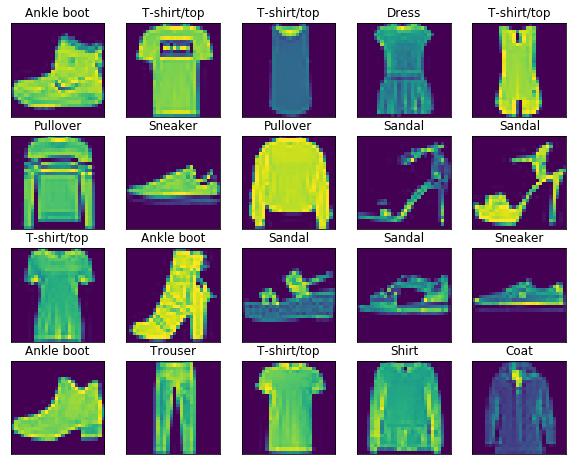

In [8]:
plt.figure(figsize=(10,10))
for i in range(0,20):
    plt.subplot(5,5, i+1)
    plt.imshow(x_train[i] )
    plt.title( target_dict[(y_train[i]) ])
    plt.xticks([])
    plt.yticks([])

In [0]:
class MLPModel:
    def __init__(self,x_train, y_train, x_test, y_test, epochs):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.epochs = epochs
        self.model = Sequential()

    
    def build_model(self, layers, activation, optimizer, regularization=None, dropout = 0.0):
        print(layers, activation, optimizer, regularization, dropout)
        for i in range(len(layers)):  
            if regularization:
                regu = l2(regularization[1]) if regularization[0] == 'l2' else l1(regularization[1])

            if i==0:
                # If First layer have to input size otherwise let it go
                self.model.add(Dense(layers[i], activation=activation, input_shape=self.x_train[0].shape, kernel_regularizer=regu))
            else:
                self.model.add(Dense(layers[i], activation=activation, kernel_regularizer=regu))

            if dropout:
                self.model.add(Dropout(dropout))
        
        self.model.add(Dense(10, activation='softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
        return self.model
    
    def train_model(self):
        return self.model.fit(self.x_train, self.y_train, batch_size=self.batch_size, epochs=self.epochs, verbose=2, validation_data=(self.x_test, self.y_test))      
        
    
    def print_head(self, n= 10):
        plt.figure(figsize=(20, 4))
        for i in range(1,n):
            ax = plt.subplot(2, n, i)
            plt.imshow(self.x_train[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
        
        

In [0]:
parameters = { 'layers': [[512, 512], [512, 512, 512]], 
                     'activation': ['relu', 'elu'],
                     'optimizer' : ['adam'],
                     'dropout' : [0.2],
                     'regularization' : [ ('l2', 0.001) ]
                   }

In [13]:

m = MLPModel(x_train_mlp, y_train_mlp, x_test_mlp, y_test_mlp, 10)
model = KerasClassifier(build_fn=m.build_model,epochs=10, batch_size=128)
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=3)
grid_result = grid_search.fit(x_train_mlp, y_train_mlp)



/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


[512, 512] relu adam ('l2', 0.001) 0.2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40000/40000 [==============================] - 8s 194us/step - loss: 1.2113 - acc: 0.7

In [14]:
final_model = grid_search.best_estimator_
final_parameters = grid_search.best_params_
print(final_parameters)

{'activation': 'relu', 'dropout': 0.2, 'layers': [512, 512, 512], 'optimizer': 'adam', 'regularization': ('l2', 0.001)}


In [0]:
y_predicted_mlp = final_model.predict(x_test_mlp)

In [46]:
y_predicted_mlp[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [0]:
# Save Model
final_model.model.save('MLP_best_model.h5')

In [30]:
mlp_accuracy_score = accuracy_score(y_predicted_mlp, y_test_mlp)* 100
print(mlp_accuracy_score)

86.72999999999999


# RandomForest

In [0]:
rf = RandomForestClassifier(n_estimators=64, n_jobs=-1)
fit_result = rf.fit(x_train_mlp, y_train_mlp)


In [0]:
y_pred_mlp = rf.predict(x_test_mlp)


In [42]:
y_pred_mlp[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [44]:
# Print result
rf_accuracy_score = accuracy_score(y_test_mlp_one_hot, y_pred_mlp)
print(rf_accuracy_score)

0.8042


# Convulational Model

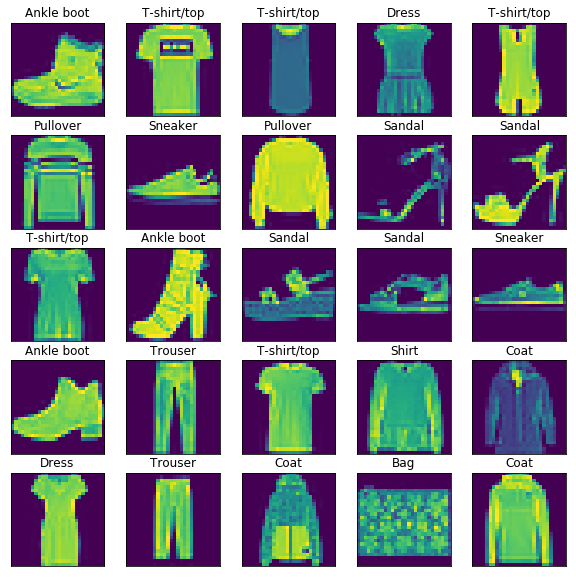

In [7]:
# See first 25 data

plt.figure(figsize=(10,10))
for i in range(0,25):
    plt.subplot(5,5, i+1)
    plt.imshow(x_train[i] )
    plt.title( target_dict[(y_train[i]) ])
    plt.xticks([])
    plt.yticks([])

In [0]:
class DataPreparation:
    def __init__(self, x_data, y_data, normalized=True):
        self. X = x_data.reshape(x_data.shape[0], 28,28,1)
        # One hot encoded
        self.Y = np_utils.to_categorical(y_data)
        
        if normalized:
            self.__normalize_data__()


    def __normalize_data__(self):
        self.X = self.X/np.float(255)

In [0]:
train_data  = DataPreparation(x_train, y_train)
test_data = DataPreparation(x_test, y_test)

In [10]:
print(train_data.Y[:5])
print(train_data.X.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(60000, 28, 28, 1)


In [0]:
parameters = {
    'layers' : [[('Conv2D' , 64 ), ('Conv2D' , 32)], [( 'Conv2D', 64) , ('Dense' , 32 )] ],
    'activation' : ['relu'],
    'optimizer' : ['adam']
}

In [0]:
class ConvolutionalModel:
    def __init__(self ,x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
        self.model = Sequential()
    
    def build_model(self, layers, activation, optimizer, dropout = 0.0 ):
        print('Parameters : Layers: {}, Activation: {}, optimizer: {}, input_shape : {}'.format(layers,activation,optimizer, self.x_train[0].shape))
        
       
        i = 0
        first_dense = True
        for layer in layers:
            print(layer)
            i+=1
            # Adding Input to the First Layer
            if i==1 :
                self.model.add(Conv2D(layer[1], kernel_size=3, activation=activation, input_shape=self.x_train[0].shape))
                self.model.add(MaxPool2D(pool_size=2))

            
            
            if layer[0] == 'Conv2D':
                self.model.add(Conv2D(layer[1], kernel_size=3, activation=activation))
                self.model.add(MaxPool2D(pool_size=2))
            else:
                if first_dense:
                    first_dense = False
                    self.model.add(Flatten())

                self.model.add(Dense(layer[1], activation=activation))
            
        # Adding Final Layer
        if first_dense:
            self.model.add(Flatten())

        self.model.add(Dense(10, activation='softmax'))
        self.model.summary()
        self.model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy'])
        
        return self.model
        
    

In [31]:
model = ConvolutionalModel(train_data.X, train_data.Y)
grid_search_classifier = KerasClassifier(build_fn=model.build_model, epochs=10, batch_size=128)
grid_search_cnn = GridSearchCV(estimator=grid_search_classifier, param_grid=parameters, cv=3 )
grid_search_fit = grid_search_cnn.fit(train_data.X, train_data.Y)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Parameters : Layers: [('Conv2D', 64), ('Conv2D', 32)], Activation: relu, optimizer: adam, input_shape : (28, 28, 1)
('Conv2D', 64)
('Conv2D', 32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 3, 3, 32)          18464     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 1, 1, 32)          0      

In [33]:
final_model_cnn = grid_search_cnn.best_estimator_
final_parameters_cnn = grid_search_cnn.best_params_
print(final_parameters_cnn)

{'activation': 'relu', 'layers': [('Conv2D', 64), ('Dense', 32)], 'optimizer': 'adam'}


In [0]:
y_predicted_cnn = final_model_cnn.predict(test_data.X)

In [39]:
cnn_accuracy = accuracy_score(y_predicted_cnn, y_test)
print(cnn_accuracy)

0.9004
